In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [3]:
import xarray as xr
import numpy as np
from typing import *
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import colors
import matplotlib.pyplot as plt
from aibedo.utilities.plotting import data_snapshots_plotting, data_mean_plotting
from aibedo.utilities.wandb_api import reload_checkpoint_from_wandb

In [4]:
plt.rcParams['figure.figsize'] = [15, 15]  # general matplotlib parameters
plt.rcParams['figure.dpi'] = 70 

In [5]:
num_workers = 2
predict_set = "val"  #  use 'same_as_test' to predict on test set, 'val' means that predictions are made on the validation set (here, CESM2)
DATA_DIR = "./data"

overrides = [f'datamodule.num_workers={num_workers}',
             f'++datamodule.prediction_data={predict_set}',
             'datamodule.eval_batch_size=5',
             'verbose=False',
             f'datamodule.data_dir={DATA_DIR}'
            ]

In [6]:
cur_run_id = None
def get_model_and_dm_from_run_id(run_id):
    global cur_run_id
    cur_run_id = run_id
    values = reload_checkpoint_from_wandb(run_id=run_id, project='AIBEDO', override_key_value=overrides, try_local_recovery=False)
    return  values['model'], values['datamodule'], values['config']

In [7]:
def get_predictions_xarray(run_id, split='predict', return_normalized_outputs=False, variables='all'):
    model, dm, cfg = get_model_and_dm_from_run_id(run_id)
    print('physics_loss_weights:', cfg.model.physics_loss_weights)
    dm.setup(stage=split)
    dataloader = dm.val_dataloader() if 'val' in split else dm.predict_dataloader()
    predictions_xarray = dm.get_predictions_xarray(model, dataloader=dataloader, return_normalized_outputs=return_normalized_outputs, variables=variables)
    del model, dm, cfg
    return predictions_xarray

# Reload and predict with some models:
#### Baseline MLP, without any constraints

In [8]:
rid_baseline = "ccmopc1x"
# ds_mlp = get_predictions_xarray(rid_baseline, split='predict')
ds_mlp = xr.open_dataset(DATA_DIR.replace('data', 'out_dir/preds/') + 'val_' + rid_baseline + '.nc')

#### MLP with all constraints (including 2nd)

In [20]:
rid_all= "1ul6rx81"  #  physics loss weights:  [0, 0.005, 1000, 1, 1]
# ds_c_all = get_predictions_xarray(rid_all, split='predict')
ds_c_all = xr.open_dataset(DATA_DIR.replace('data', 'out_dir/preds/') + 'val_' + rid_all + '.nc')

In [10]:
snapshots = [1, 10, -50, -45, -38, -36]   # which timesteps to plot
pkwargs = dict(snapshots_to_plot=snapshots, same_colorbar_for_preds_and_targets=False, robust=False, marker_size=1, coastlines_linewidth=0.5)  # plotting kwargs
vmin1 = vmax1 = vmin2 = vmax2 = vmin3 = vmax3 = vmin4 = vmax4 = None  # dummy vars

# Global maps


The predictions are for 6 arbitrary snapshots of the ERA5 test set
- First row: Targets 
- 2nd row: Predictions of MLP without constraints
- 3rd row: Predictions of MLP with constraints

#### Surface pressure

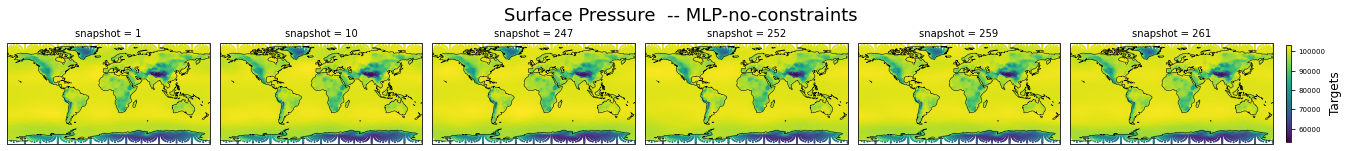

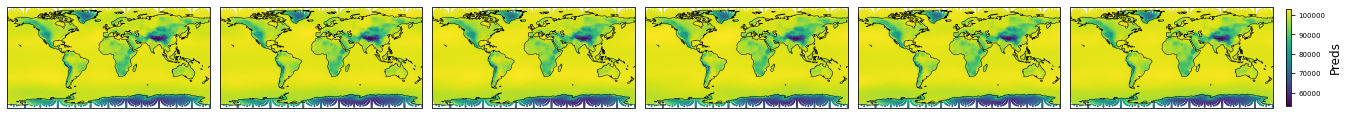

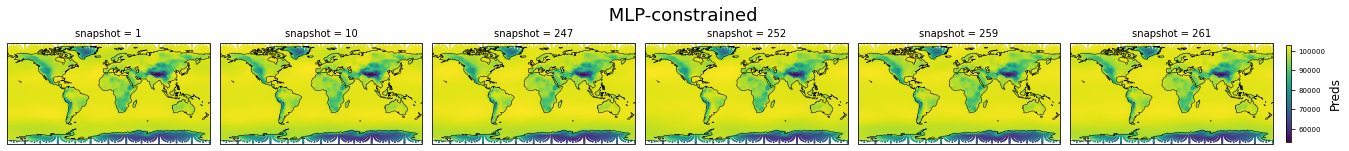

In [11]:
var= 'ps'
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

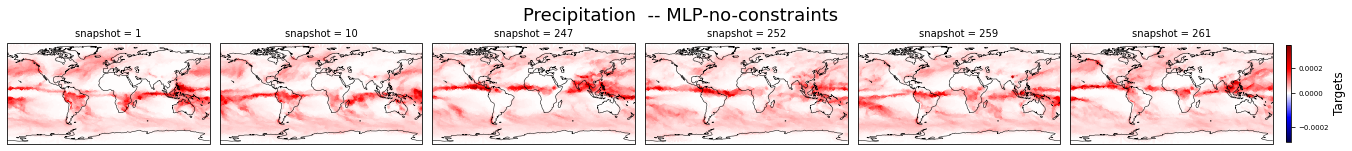

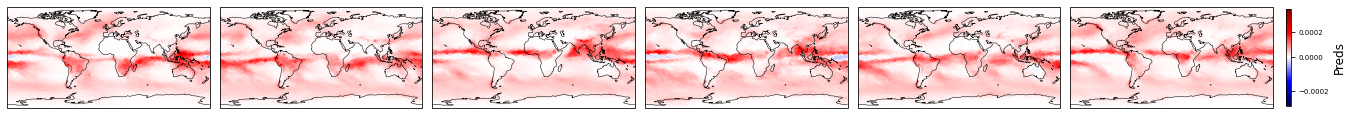

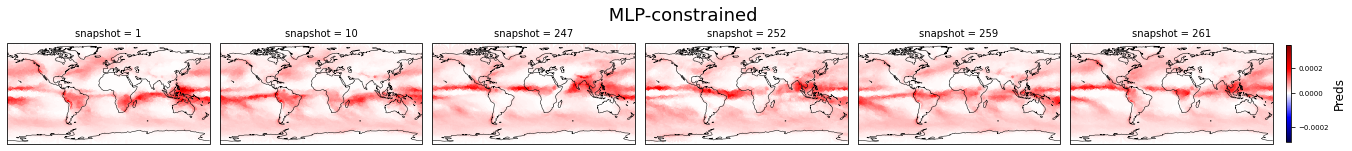

In [13]:
var= 'pr'
cmap = 'seismic'
pkwargs2 = dict(cmap=cmap, norm=colors.TwoSlopeNorm(vmin=vmin2, vcenter=0.0, vmax=vmax2) if vmin2 else None) 

pcs21 = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, **pkwargs, **pkwargs2, vars_to_plot=[var])
pcs22 = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", plot_only_preds=True, **pkwargs, **pkwargs2, vars_to_plot=[var])


cbar21p, cbar21t, cbar22p = pcs21['pr']['preds'].cbar, pcs21['pr']['targets'].cbar, pcs22['pr']['preds'].cbar
vmin2 = min(cbar21p.vmin, cbar22p.vmin)
vmax2 = cbar21t.vmax
assert cbar21p.vmin == cbar21t.vmin and cbar22p.vmax == cbar21t.vmax

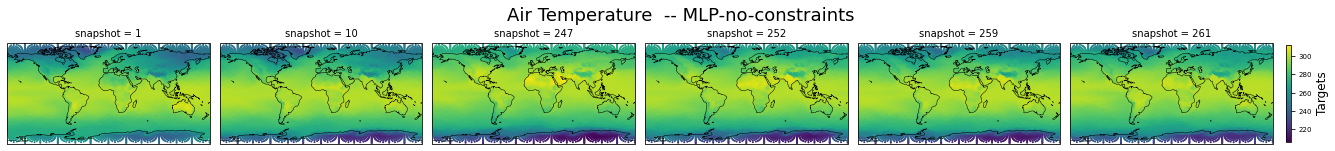

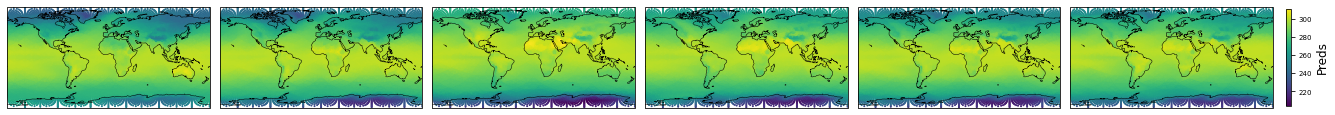

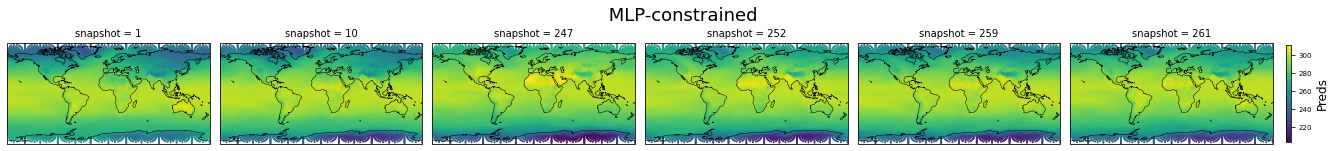

In [14]:
var= 'tas'
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

## Plot errors
- 1st row: Predictions of MLP without constraints
- 2nd row: Predictions of MLP with constraints

#### First, surface pressure

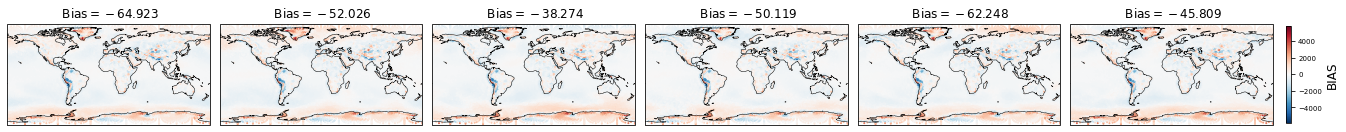

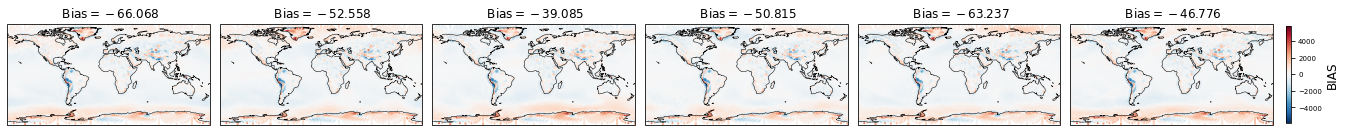

In [15]:
var= 'ps'
for ds in [ds_mlp, ds_c_all]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", cmap=None, **pkwargs2)

#### Precipitation

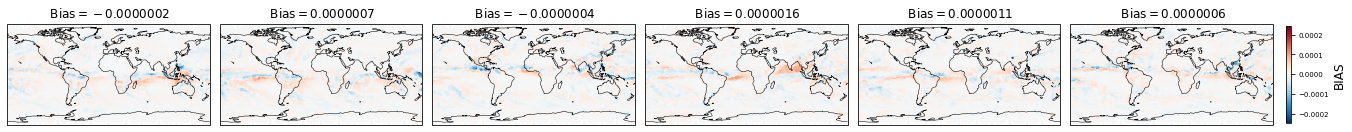

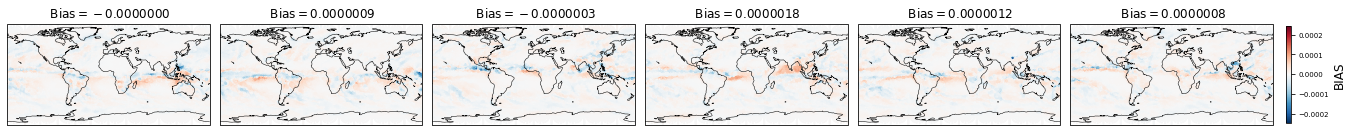

In [16]:
var= 'pr'
for ds in [ds_mlp, ds_c_all]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", cmap=None, **pkwargs2)

#### Temperature

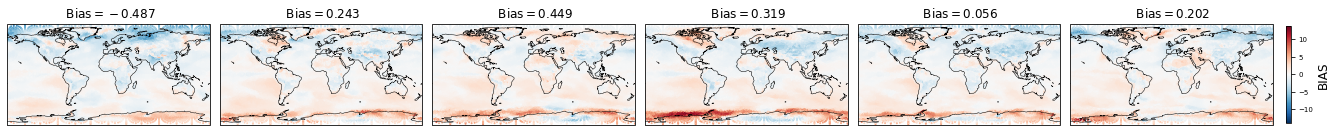

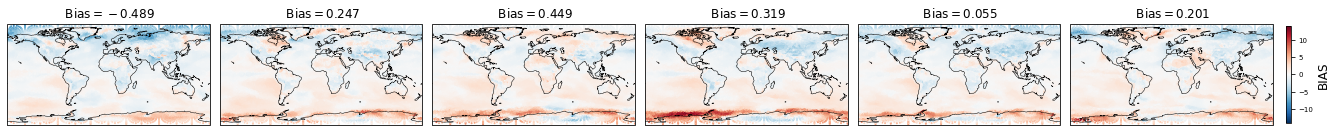

In [17]:
var= 'tas'
for ds in [ds_mlp, ds_c_all]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", cmap=None, **pkwargs2)

## Temporal mean

--> Average over the full time dimension

- 1st row: Targets (temporally averaged)
- 2nd row: Predictions of MLP without constraints
- 3rd row: Error of MLP without constraints
- 4th row: Error of MLP with constraints

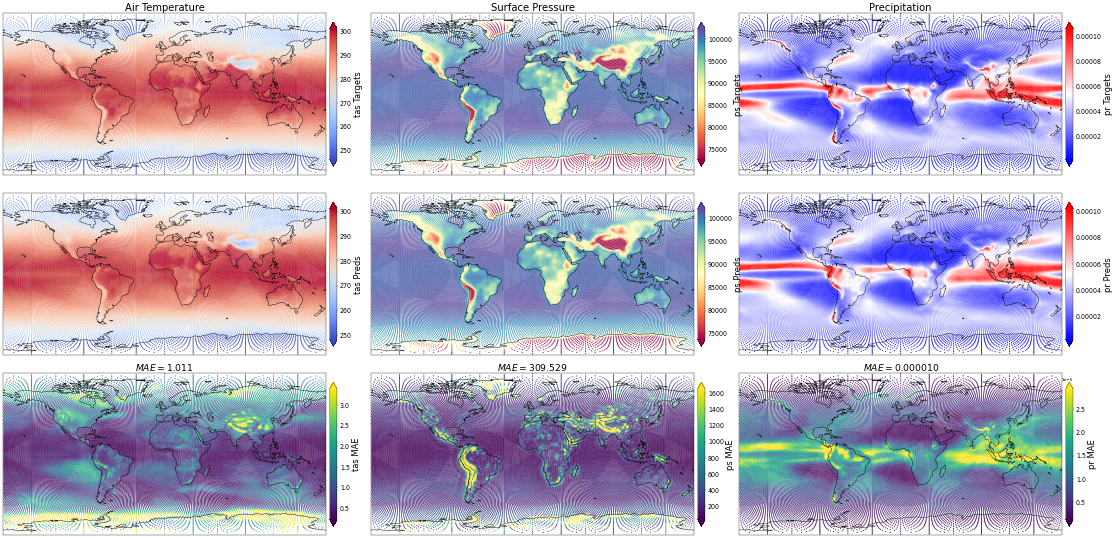

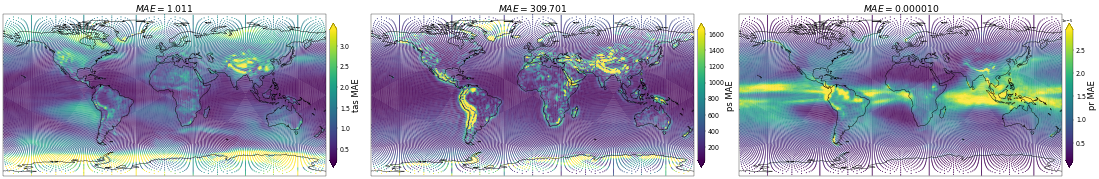

In [18]:
plt.rcParams['figure.dpi'] = 30 
for var in ['pr', 'tas', 'ps']:
    for ds in [ds_mlp, ds_c_all]:
        ds[f'{var}_mae'] = np.abs(ds[f'{var}_preds'] - ds[f'{var}_targets'])
        ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']

pkwargs3 = dict(vars_to_plot="denormalized", error_to_plot='mae')
_ = data_mean_plotting(ds_mlp, **pkwargs3)
_ = data_mean_plotting(ds_c_all,  **pkwargs3, plot_only_errors=True)